# Normalisation of T2W-MRI using Fisher-Rao metric and functional data analysis

We can put all the needed libraries there

In [31]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import fdasrsf as fs

## Unormalized data

We need first to investigate the unormalized data. To do so, we can construct the PDFs of the T2W image.

#### Load the data

In [12]:
data_t2w_norm = np.load('../data/t2w/data_raw_norm.npy')
patient_sizes = np.load('../data/t2w/patient_sizes.npy')
label = np.load('../data/t2w/label.npy')

print '-----> Data loaded'

-----> Data loaded


#### Function to normalised the data

In [8]:
# Define the function to compute the Normalised Mean Intensity
def nmi(data):
    # get the minimum 
    #min_data = np.min(data)
    min_data = -1.
    print 'mini: {}'.format(min_data)

    # get the maximum
    #max_data = np.max(data)
    max_data = 1.
    print 'maxi: {}'.format(max_data)

    # find the mean
    mean_data = np.mean(data)
    print 'mean: {}'.format(mean_data)

    # return the nmi
    return mean_data / (max_data - min_data)

#### Compute the histogram for the raw T2W-MRI

Initializing...
Compute Karcher Mean of 17 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


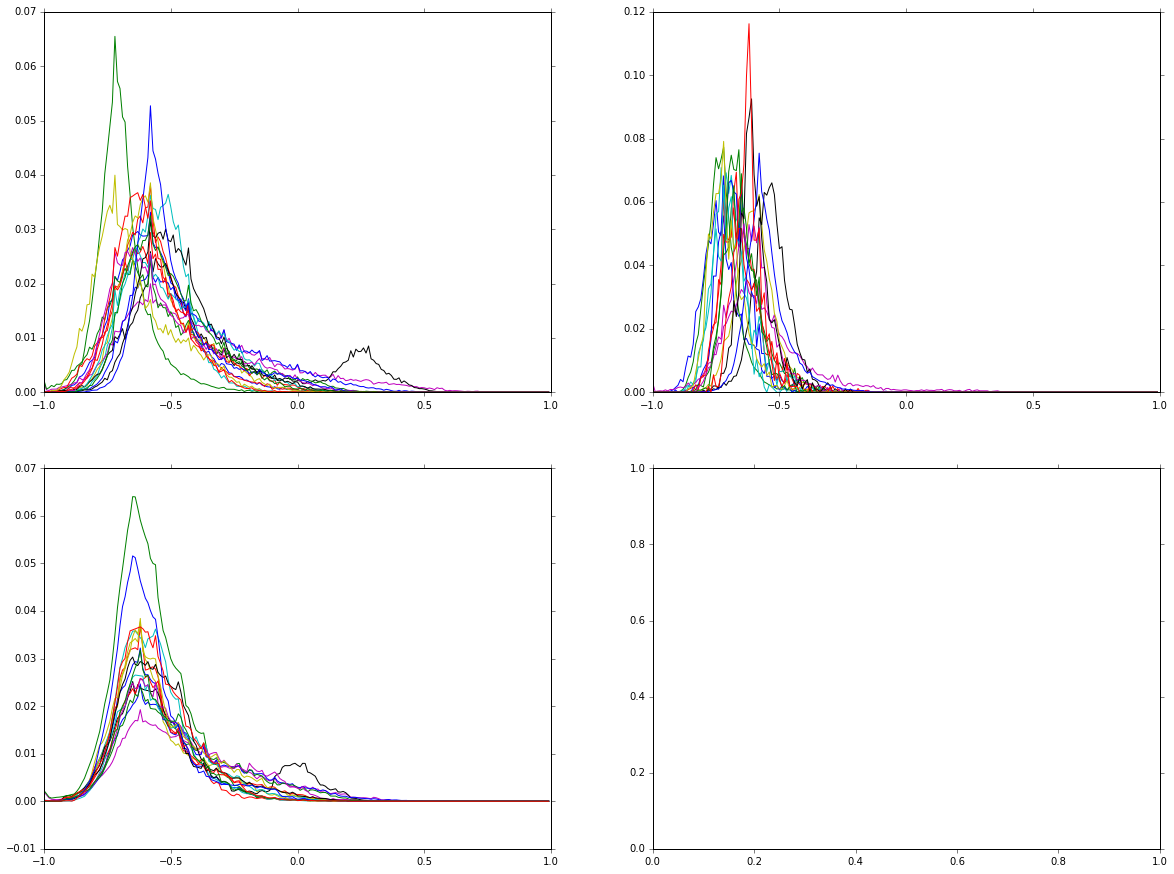

In [35]:
# To make the future plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

global_hist_t2w = np.zeros((200, len(patient_sizes)))
global_hist_t2w_cap = np.zeros((200, len(patient_sizes)))
nmi_raw = []

for pt in xrange(len(patient_sizes)):
    
    # Find the index of the current patients
    if (pt == 0):
        start_idx = 0
        end_idx = patient_sizes[pt]
    else:
        start_idx = np.sum(patient_sizes[0 : pt])
        end_idx = np.sum(patient_sizes[0 : pt + 1])

    ##### RAW DATA #####
    # Compute the histogram for the whole data
    nb_bins = 200
    hist, bin_edges = np.histogram(data_t2w_norm[start_idx : end_idx], bins=nb_bins, range=(-1., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[0, 0].plot(bin_edges[0 : -1], hist, label='Patient '+str(pt))
    
    # Append the histogram to the global list of histogram
    global_hist_t2w[:, pt] = hist

    # Compute the histogram for the cancer data
    nb_bins = 200
    sub_data = data_t2w_norm[start_idx : end_idx]
    cap_data = sub_data[np.nonzero(label[start_idx : end_idx] == 1)[0]]
    hist, bin_edges = np.histogram(cap_data, bins=nb_bins, range=(-1., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[0, 1].plot(bin_edges[0 : -1], hist)
    
    # Append the histogram to the global list of histogram
    global_hist_t2w_cap[:, pt] = hist
    
    time = bin_edges[0 : -1]
    
# Align all the curve using FDASRSF
out = fs.srsf_align(global_hist_t2w, time, showplot=False)
axes[1, 0].plot(time, out.fn)

In [34]:
print out.gam

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.00207261  0.00138174  0.00207261 ...,  0.02901656  0.00829045
   0.00138174]
 [ 0.00415555  0.00277037  0.00415555 ...,  0.05817774  0.03305211
   0.00277037]
 ..., 
 [ 0.99000023  0.99000023  0.99000023 ...,  0.99000023  0.99000023
   0.99000023]
 [ 0.99500011  0.99500011  0.99500011 ...,  0.99500011  0.99500011
   0.99500011]
 [ 1.          1.          1.         ...,  1.          1.          1.        ]]
